In [2]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import torch
import random
import torch.nn as nn
import sklearn
import collections
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import json
from torch.optim import Adam
import pylab
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')
from functions import load_model, save_model, Dataset, mse_loss
from sklearn.metrics import roc_curve, auc

Mounted at /content/gdrive


## Dataset Classes

In [11]:
# Weighted Dataset class
class Weighted_Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, weights):
        self.X = X
        self.y = y
        self.weights = weights

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return [self.X[index].astype('float32'), self.y[index].astype('float32'), self.weights[index].astype('float32')]

    def collate_fn(self, batch):
        X = [torch.tensor(sample[0]).float() for sample in batch]
        y = [torch.tensor(sample[1]).float() for sample in batch]
        weights = [torch.tensor(sample[2]).float() for sample in batch]
        return torch.stack(X, 0), torch.stack(y, 0), torch.stack(weights, 0)

    def create_dataloader(self, batch_size, shuffle=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle)

In [12]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return [torch.from_numpy(self.X[index]), torch.from_numpy(self.y[index])]

    def collate_fn(self, batch):
        X = [torch.tensor(sample[0]).float() for sample in batch]
        y = [torch.tensor(sample[1]).float() for sample in batch]
        return torch.stack(X, 0), torch.stack(y, 0)

    def create_dataloader(self, batch_size, shuffle=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle)

## Load Data

In [13]:
# Load Background data, which will be used for training
filename = 'BKG_dataset.h5'
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)

(640000, 57)


In [14]:
def calculate_class_weights(x_in, bins):
    x = np.reshape(x_in, (-1, 19, 3, 1))
    pT = x[:, 1:, 0, 0]
    pT_sum = np.sum(pT, axis=1)

    freq, bin_edges = np.histogram(pT_sum, bins=bins)
    indxs = np.digitize(pT_sum, bin_edges[:-1]) - 1
    class_weights = 1 / freq
    class_weights[np.isinf(class_weights)] = 0.0

    weights = class_weights[indxs]

    #weights = np.ones((x_in.shape[0])) * 1/len(x_in)

    return weights

In [15]:
# Calculate the weights for each event, so that underrepresented parameter regimes are more heavily weighted during training
BINS = 100
weights_train = calculate_class_weights(X_train, bins=BINS)
weights_val = calculate_class_weights(X_val, bins=BINS)

print(weights_train.shape)

(640000,)


<ipython-input-14-7ba9f0463619>:8: RuntimeWarning: divide by zero encountered in true_divide
  class_weights = 1 / freq


In [16]:
def scale_array(array, lower_bound, upper_bound):
    # Get the minimum and maximum values of the array
    min_value = np.min(array)
    max_value = np.max(array)

    # Scale the array using linear interpolation
    scaled_array = np.interp(array, (min_value, max_value), (lower_bound, upper_bound))

    return scaled_array

In [17]:
weights_train = scale_array(weights_train, 0.1, 1)
weights_val = scale_array(weights_val, 0.1, 1)

In [18]:
print(np.unique(weights_train))

[0.1        0.10000631 0.10001911 0.10004448 0.10008708 0.10015726
 0.10025952 0.10039427 0.10062297 0.10083207 0.10127276 0.10156047
 0.10209587 0.10259913 0.10349992 0.10491601 0.10584214 0.10714084
 0.10927634 0.11124799 0.11323329 0.1147521  0.11636164 0.11874801
 0.12194924 0.12646861 0.12727076 0.13333138 0.14499807 0.14999808
 0.15624809 0.16922889 0.17499814 0.18181633 0.22856969 0.24999831
 0.27999837 0.32499848 0.39999864 0.54999898 1.        ]


In [19]:
# Initialize datasets
train_dataset = Weighted_Dataset(X=X_train, y=X_train, weights=weights_train)
test_dataset = Dataset(X=X_test, y=X_test)
val_dataset = Weighted_Dataset(X=X_val, y=X_val, weights=weights_val)

In [20]:
BATCH_SIZE = 1024

In [21]:
# Initialize dataloaders
train_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
val_loader = val_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
batch_X, batch_y, batch_weights = next(iter(train_loader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    f"  weights: {list(batch_weights.size())}\n")

Sample batch:
  X: [1024, 57]
  y: [1024, 57]
  weights: [1024]



## DNN and Trainer Classes

In [22]:
class DNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """input_dim: dimension of the input data.
        latent_dim: dimension of the latent space. Should be smaller than all of the other layers.
        num_nodes: two element array containing the number of nodes in the two hidden layers."""
        super(DNN_AE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x_in):
        """Forward through the autoencoder with relu activation."""

        # Encoder
        z = F.relu(self.fc1(x_in))
        z = F.relu(self.fc2(z))

        # Decoder
        z = F.relu(self.fc3(z))
        z = self.fc4(z)
        return z

In [23]:
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch.

        returns: average loss over most recent {num_batches_avg} batches, loss over most recent batch
        """

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets, weights = batch
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets, weights)
            loss.backward()
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true, weights = batch
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, y_true, weights)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []

        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)

        return np.vstack(model_outputs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'average train loss over most recent {self.num_batches_avg} batches: {avg_train_loss},'
            f'average val loss over most recent {self.num_batches_avg} batches: {avg_val_loss},'
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

## Initialize Model and Train

In [24]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE = 6
NUM_EPOCHS = 10

In [25]:
# Initialize model
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = 32
LATENT_DIM = 8
dense_AE = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
print(dense_AE.named_parameters)

<bound method Module.named_parameters of DNN_AE(
  (fc1): Linear(in_features=57, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=57, bias=True)
)>


In [29]:
# Define the loss function with class weights
def loss_fn(x, y, weights):

    # Define a mask which is False wherever an element of y is 0, True otherwise
    mask = 1 * (y != 0)

    # Apply sample weighting
    weighted_mask = mask * weights.unsqueeze(1)

    # Calculate the weighted MSE loss using x and y
    loss = torch.mean(weighted_mask * ((x - y) ** 2))

    return loss

In [30]:
# Initialize optimizer, lr scheduler, trainer
optimizer = Adam(params=dense_AE.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, verbose=True)
trainer = Trainer(model=dense_AE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [31]:
# Train
best_model = trainer.train(
    num_epochs=NUM_EPOCHS, patience=PATIENCE,
    train_dataloader=train_loader, val_dataloader=val_loader)

Epoch: 1 | average train loss over most recent 25 batches: 0.07479718640446663,average val loss over most recent 25 batches: 0.13181750789284707,patience counter: 6
Epoch: 2 | average train loss over most recent 25 batches: 0.051925432160496714,average val loss over most recent 25 batches: 0.07646379590034486,patience counter: 6
Epoch: 3 | average train loss over most recent 25 batches: 0.04427610598504543,average val loss over most recent 25 batches: 0.07416667312383651,patience counter: 6
Epoch: 4 | average train loss over most recent 25 batches: 0.05556082099676132,average val loss over most recent 25 batches: 0.06536997087299824,patience counter: 6
Epoch: 5 | average train loss over most recent 25 batches: 0.036674023494124415,average val loss over most recent 25 batches: 0.06653481185436248,patience counter: 5
Epoch: 6 | average train loss over most recent 25 batches: 0.03553538821637631,average val loss over most recent 25 batches: 0.04346804421395063,patience counter: 6
Epoch: 7

In [32]:
# Save model
save_model(best_model, 'DNN_AE_V9_tests')

In [33]:
# Load model
dense_AE = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dense_AE = load_model(dense_AE, 'DNN_AE_V9_tests')
trainer = Trainer(model=dense_AE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

## Prediction

In [34]:
bkg_prediction = trainer.predict_step(dataloader=test_loader)

<ipython-input-12-b421a1571757>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-12-b421a1571757>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [35]:
# add correct signal labels
signal_labels = ['Ato4l', 'hChToTauNu', 'hToTauTau', 'leptoquark']

In [36]:
# add correct path to signal files
drive_path = '/content/gdrive/MyDrive/Penn/Colab/Data/'
signals_file = [drive_path+label+'_dataset.h5' for label in signal_labels]
print(signals_file)

['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hChToTauNu_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hToTauTau_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/leptoquark_dataset.h5']


In [37]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
    signal_data.append(test_data)

print(np.array(signal_data).shape)

(4,)


<ipython-input-37-fcddd4288aef>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(signal_data).shape)


In [38]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = dense_AE(torch.tensor(signal_data[i], requires_grad=False).float())
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

In [39]:
def AD_score(y, x):

    # Masked mse AD Score:
    mask = (y != 0)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [40]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(AD_score(X_test,
                           bkg_prediction.astype(np.float32)))
for i, signal_X in enumerate(signal_data):
    total_loss.append(AD_score(signal_X,
                               signal_results[i][2].detach().numpy().astype(np.float32)))

In [41]:
print(total_loss[0].shape)

(200000,)


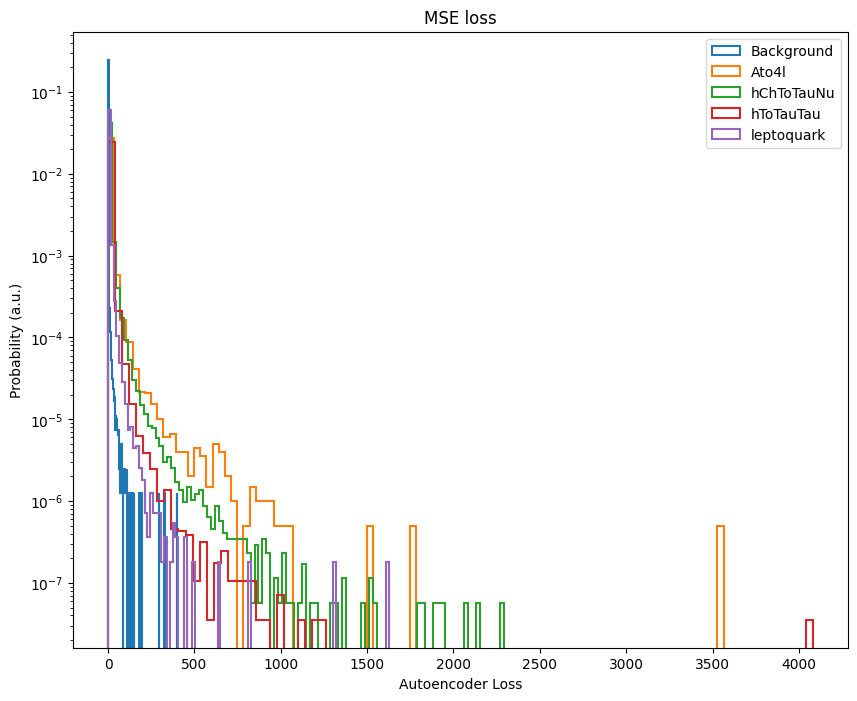

In [42]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

#plt.hist(total_loss[0], bins=bin_size, label='background', density = True, histtype='step', fill=False, linewidth=1.5)
#plt.hist(total_loss[1], bins=bin_size, label='Ato4l', density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

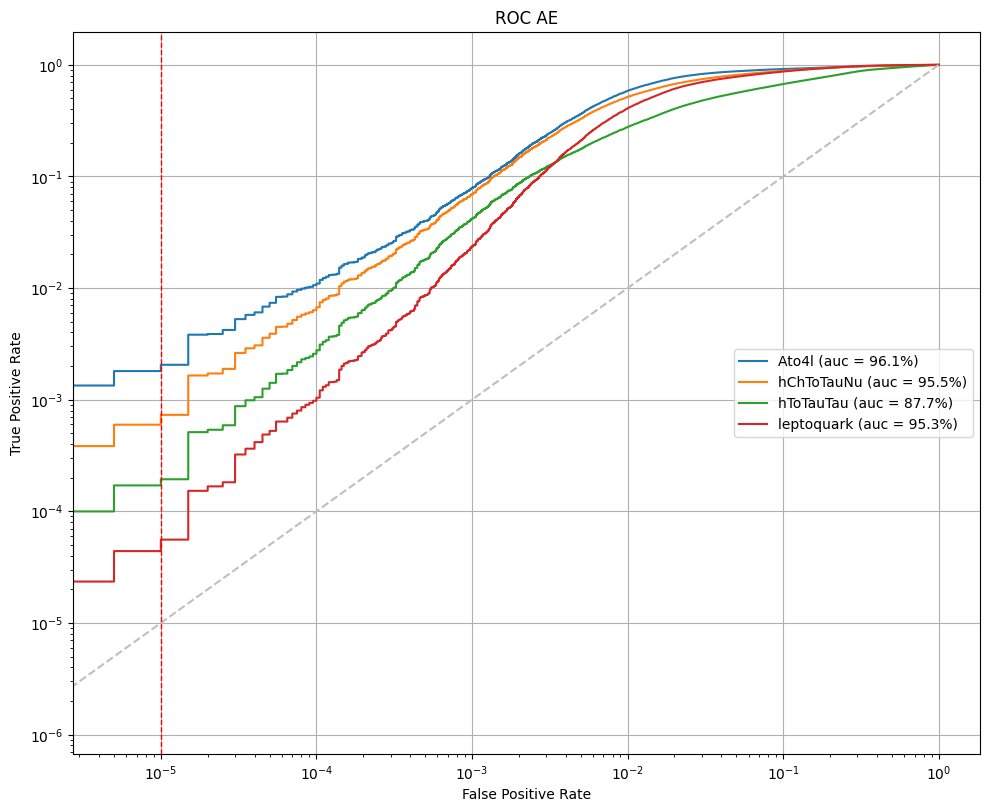

In [43]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()

## Evaluation

In [44]:
# Calculate the threshold for a give rejection rate using the background datset

REJECTION_RATE = pow(10, 4)


# Calculate fpr, tpr, thresholds
trueVal = target_background
predVal_loss = np.array(total_loss[0])
fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss, drop_intermediate=False)

# Loop over thresholds
for i, thresh in enumerate(threshold_loss):
    preds = (predVal_loss >= thresh)
    rejection_rate = (len(preds) - np.sum(preds)) / np.sum(preds) # number of background / number of anomaly

    # Breaking
    if rejection_rate < REJECTION_RATE:
        break

    threshold = thresh # update threshold

pred_test = (predVal_loss >= threshold)
print(f'\nrejection rate = {(len(pred_test) - np.sum(pred_test)) / np.sum(pred_test):.2f}')
print(f'threshold = {threshold:.2f}\n\n')


rejection rate = 10525.32
threshold = 94.23




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-44-ef13861a7d00>:14: RuntimeWarning: divide by zero encountered in long_scalars
  rejection_rate = (len(preds) - np.sum(preds)) / np.sum(preds) # number of background / number of anomaly


In [45]:
from IPython.display import Javascript

<IPython.core.display.Javascript object>


Ato4l:
length of dataset: 55969
TP = 574
TPR = 0.0103



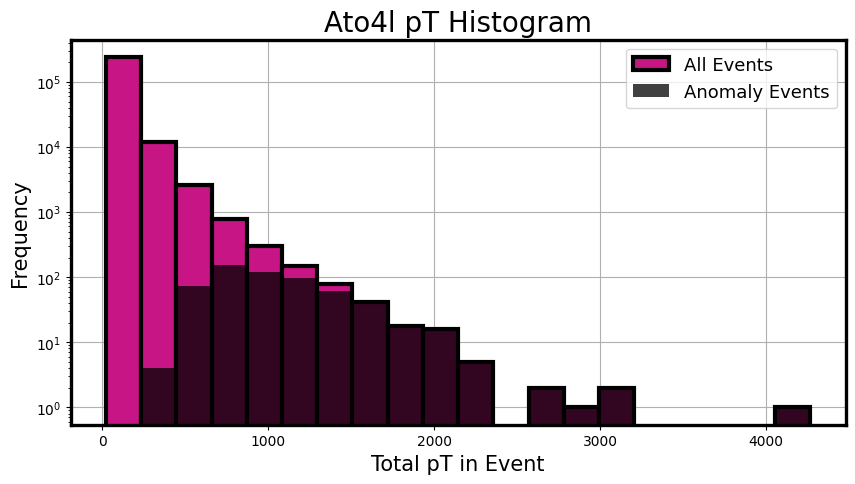

<ipython-input-46-37caf4cd36cb>:57: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(bin_centers, pT_hist_B/pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=2.5, zorder=2)


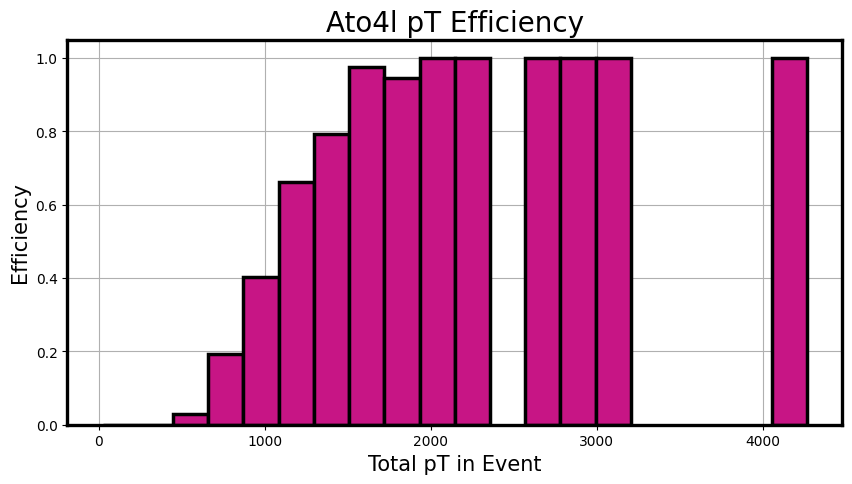

_________________________________________________________________________________________________

hChToTauNu:
length of dataset: 760272
TP = 4627
TPR = 0.0061



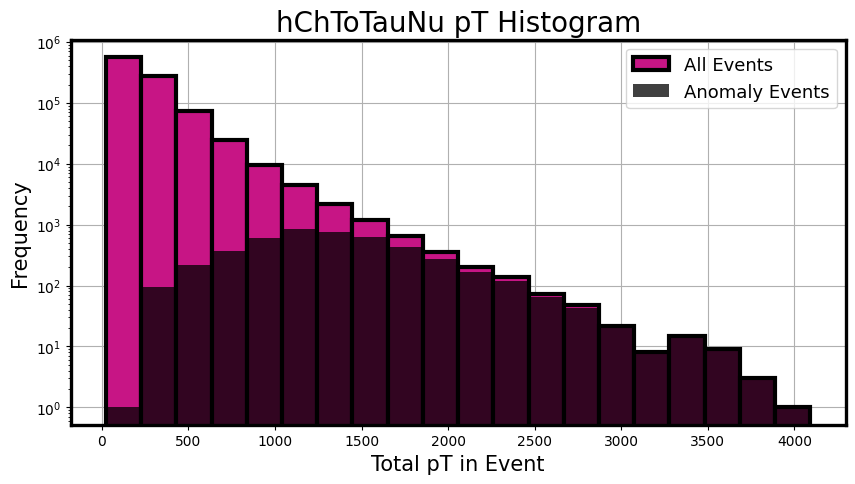

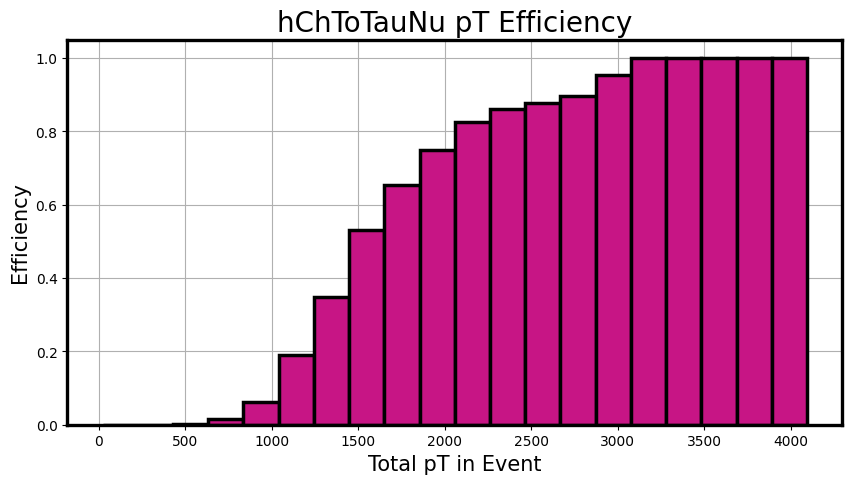

_________________________________________________________________________________________________

hToTauTau:
length of dataset: 691283
TP = 1687
TPR = 0.0024



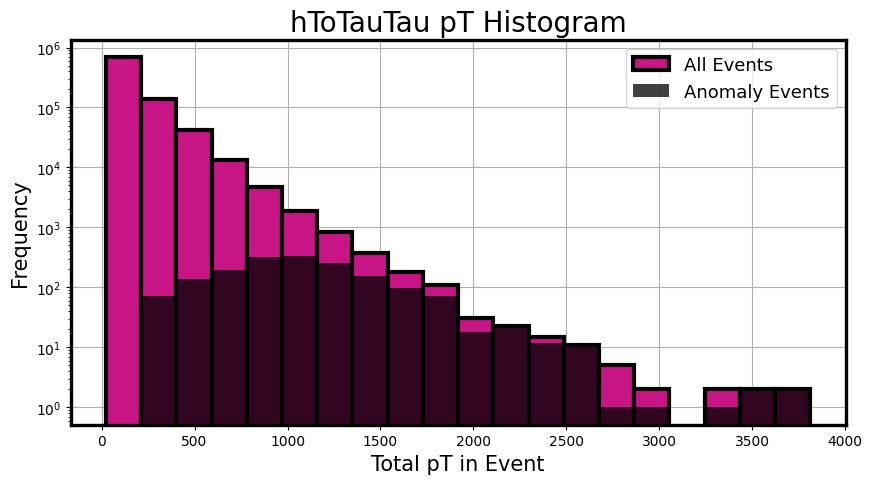

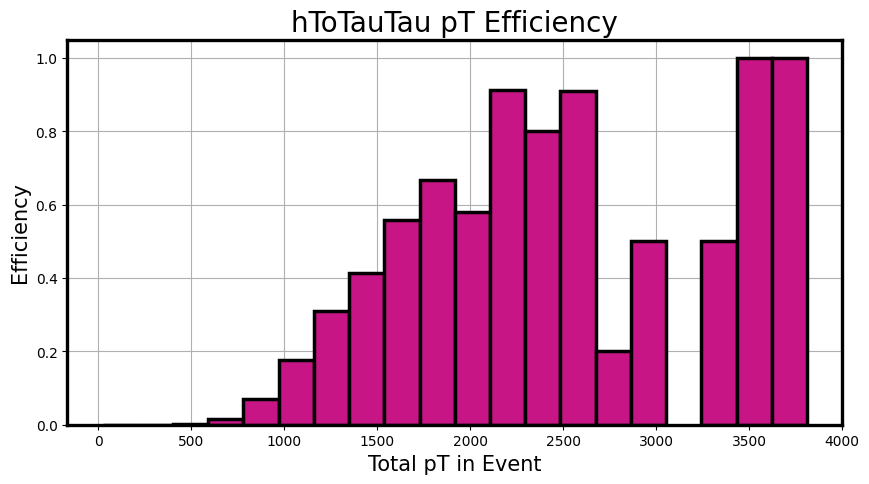

_________________________________________________________________________________________________

leptoquark:
length of dataset: 340544
TP = 319
TPR = 0.0009



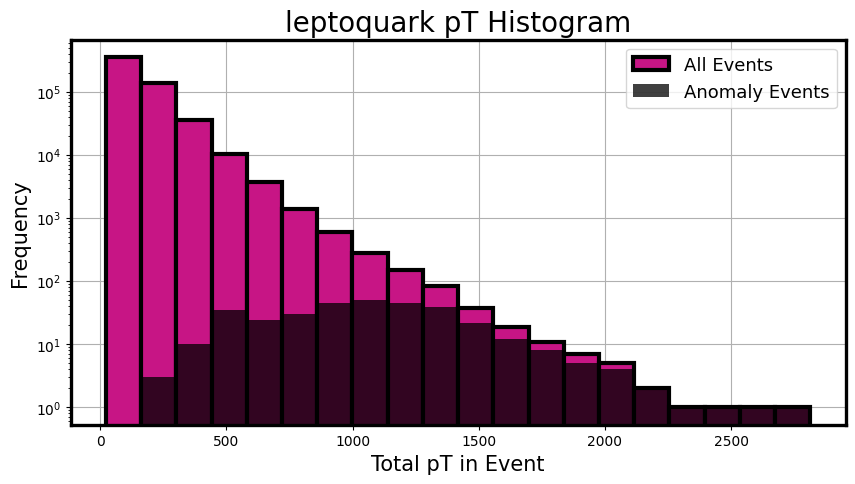

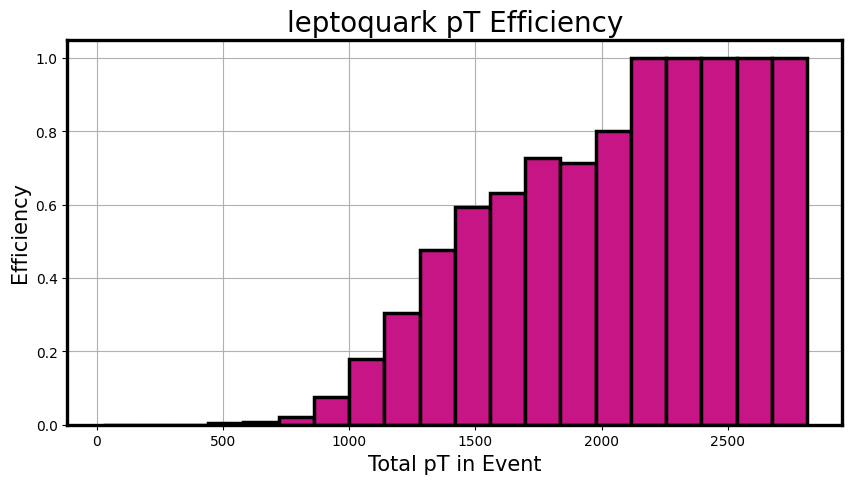

_________________________________________________________________________________________________


In [46]:
# Calcalate the TPR and efficiency of each signal dataset


display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 20000})''')) # No scroll bar

# Loop over signal datasets
for i, label in enumerate(labels):
    if i ==0: continue # background

    # Calculate TPR
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    true_indices = np.nonzero(trueVal)[0] # true anomaly indices
    predVal = 1 * (np.concatenate((total_loss[i], total_loss[0])) >= threshold) # 1=anomaly, 0=bkg
    pred_indices = np.nonzero(predVal)[0] # indices of anomaly prediction
    TP = len(np.intersect1d(pred_indices, true_indices)) # the number of elements shared between trueVal and predVal
    TPR = TP / np.sum(trueVal)

    # Printing
    print(f'\n{label}:')
    print(f'length of dataset: {total_loss[i].shape[0]}')
    print(f'TP = {TP}')
    print(f'TPR = {TPR:.4f}\n')

    # Get pT from data
    X = np.concatenate((signal_data[i-1], X_test)).reshape(-1, 19, 3, 1) # Data beore going through model
    pT = X[:, 1:, 0, 0]
    pT_max = np.max(pT, axis=1) # Maximum pT in each event
    pT_sum = np.sum(pT, axis=1) # Sum of the pT in each event

    # Make histograms
    pT_hist_A, edges_A = np.histogram(pT_sum, bins=20) # all events
    pT_hist_B, edges_B = np.histogram(pT_sum[pred_indices], bins=20, range=(pT_sum.min(), pT_sum.max())) # only events predicted as anomalous
    bin_centers = edges_A[0:-1] + ((edges_A[1] - edges_A[0])/2)


    # Plot Histograms
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Histogram', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.bar(bin_centers, pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=3, zorder=2, label='All Events')
    plt.bar(bin_centers, pT_hist_B, width=(edges_A[1] - edges_A[0]), color='k', zorder=3, label='Anomaly Events', alpha=0.75)
    plt.yscale('log')
    plt.legend(fontsize=13)
    plt.show()
    print('')

    # Plot Efficiency
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Efficiency', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Efficiency', fontsize=15)
    plt.bar(bin_centers, pT_hist_B/pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=2.5, zorder=2)
    plt.show()
    print('_________________________________________________________________________________________________')